In [10]:
import geopandas
import obspy.clients.fdsn
import project
import shapely

# Download network metadata for CSN

In [ ]:
client = obspy.clients.fdsn.Client()

inventory = client.get_stations(
    endafter=obspy.UTCDateTime(),
    level='channel',
    network='C,C1'
)

stations = pd.DataFrame([
    dict(
        network=network.code,
        station=station.code,
        location=channel.location_code,
        channel=channel.code,
        longitude=station.longitude,
        latitude=station.latitude,
        elevation=station.elevation,
        start_time=channel.start_date.timestamp,
        end_time=channel.end_date.timestamp if station.end_date is not None else np.nan
    )
    for network in inventory
    for station in network
    for channel in station
])
stations = stations[stations['channel'].str.match('[BSH][HN]')]
stations['start_time'] = pd.to_datetime(stations['start_time']*1e9, utc=True)
stations['end_time'] = pd.to_datetime(stations['end_time']*1e9, utc=True)
stations.to_hdf('../data/stations.hdf5', key='stations')

## Nominal grid

In [4]:
def station_grid(lon_min, lon_max, lat_min, lat_max, dlat, dlon, hex_pack=False):
    '''
    Create a grid of stations.
    
    Args
    ----
    lon_min
    '''
    longitude, latitude = np.mgrid[lon_min: lon_max: dlon, lat_min: lat_max: dlat]
    if hex_pack is True:
        offset = np.ones_like(latitude) * np.mean(np.diff(latitude))/2
        offset[::2] = 0
        latitude += offset

    stations = geopandas.GeoDataFrame(
        dict(
            longitude=longitude.flatten(), 
            latitude=latitude.flatten()
        ),
        geometry=geopandas.points_from_xy(
            longitude.flatten(), 
            latitude.flatten()
        )
    )
    
    longitude_code = np.repeat([chr(ord('A') + i) for i in range(longitude.shape[0])], longitude.shape[1])
    latitude_code = np.tile([f'{i:02d}' for i in range(longitude.shape[1])], longitude.shape[0])
    stations['station'] = pd.Series(longitude_code) + pd.Series(latitude_code)

    return stations

def drop_redundant_stations(proposed_stations, existing_stations, dist_thresh):
    drop = list()
    dist_thresh = 0.2

    for idx, station in proposed_stations.iterrows():
        min_dist = existing_stations.distance(station['geometry']).min()
        if min_dist < dist_thresh:
            drop.append(idx)

    return proposed_stations.drop(index=drop)

In [5]:
csn_stations = pd.read_hdf('../data/stations.hdf5')
csn_stations = geopandas.GeoDataFrame(
    csn_stations,
    geometry=geopandas.points_from_xy(csn_stations['longitude'], csn_stations['latitude'])
)
csn_stations = csn_stations[csn_stations['channel'].str.match('[BH]H')]
csn_stations = csn_stations.drop_duplicates(subset=['network', 'station'])

In [8]:
onshore_stations = station_grid(-72, -70.1, -34, -26.7, 0.4, 0.4, hex_pack=True)
onshore_stations = onshore_stations[onshore_stations.within(project.CHILE_GEOM)]
onshore_stations['station'] = 'L' + onshore_stations['station']
onshore_stations = drop_redundant_stations(onshore_stations, csn_stations, 0.2)

# offshore_stations = station_grid(-73, -71, -34, -26.7, 0.5, 0.5, hex_pack=True)
# offshore_stations = offshore_stations[~offshore_stations.within(CHILE_GEOM)]
# offshore_stations['station'] = 'O' + offshore_stations['station']

In [12]:
obs = list()
for ioff in range(15):
    x1, y1 = project.TRENCH_TRACE.interpolate(0.5*ioff).xy
    x1, y1 = x1[0], y1[0]
    pt = shapely.geometry.Point(x1, y1)
    ln = shapely.geometry.LineString([
        [x1, y1],
        [-70.5, y1]
    ])
    inter = project.CHILE_GEOM.boundary.intersection(ln)
    if isinstance(inter, shapely.geometry.MultiPoint):
        inter = inter.geoms[0]
    coast_x = inter.xy[0][0]
    obs.append([x1-0.25, y1])
    obs.append([x1+0.25*(coast_x-x1), y1])
    obs.append([x1+0.75*(coast_x-x1), y1])
obs = np.array(obs)

offshore_stations = geopandas.GeoDataFrame(
    dict(
        longitude=obs[:, 0],
        latitude=obs[:, 1],
    ),
    geometry=geopandas.points_from_xy(obs[:, 0], obs[:, 1])
)

In [14]:
# # SCENARIO A
# scenario = 'A'
# mini_arrays = np.array([
#     [-71.75, -34], # Southern
#     [-71.25, -32.25],
#     [-71.4, -30.5], # Central
#     [-71, -28.75],
#     [-70.75, -27] # Northern
# ])

# SCENARIO B
scenario = 'B'
mini_arrays = np.array([
    [-71.55, -33.5], # Southern
    [-71.4, -30.5], # Central
    [-70.75, -27.5] # Northern
])


# # SCENARIO C
# scenario = 'C'
# mini_arrays = np.array([
#     [-71.45, -32.9], # Southern N
#     [-71.55, -33.5], # Southern S
#     [-71.4, -30.2], # Central N
#     [-71.4, -30.8], # Central S
#     [-70.75, -27.5], # Northern N
#     [-70.95, -28.1] # Northern S
# ])

## Phased arrays

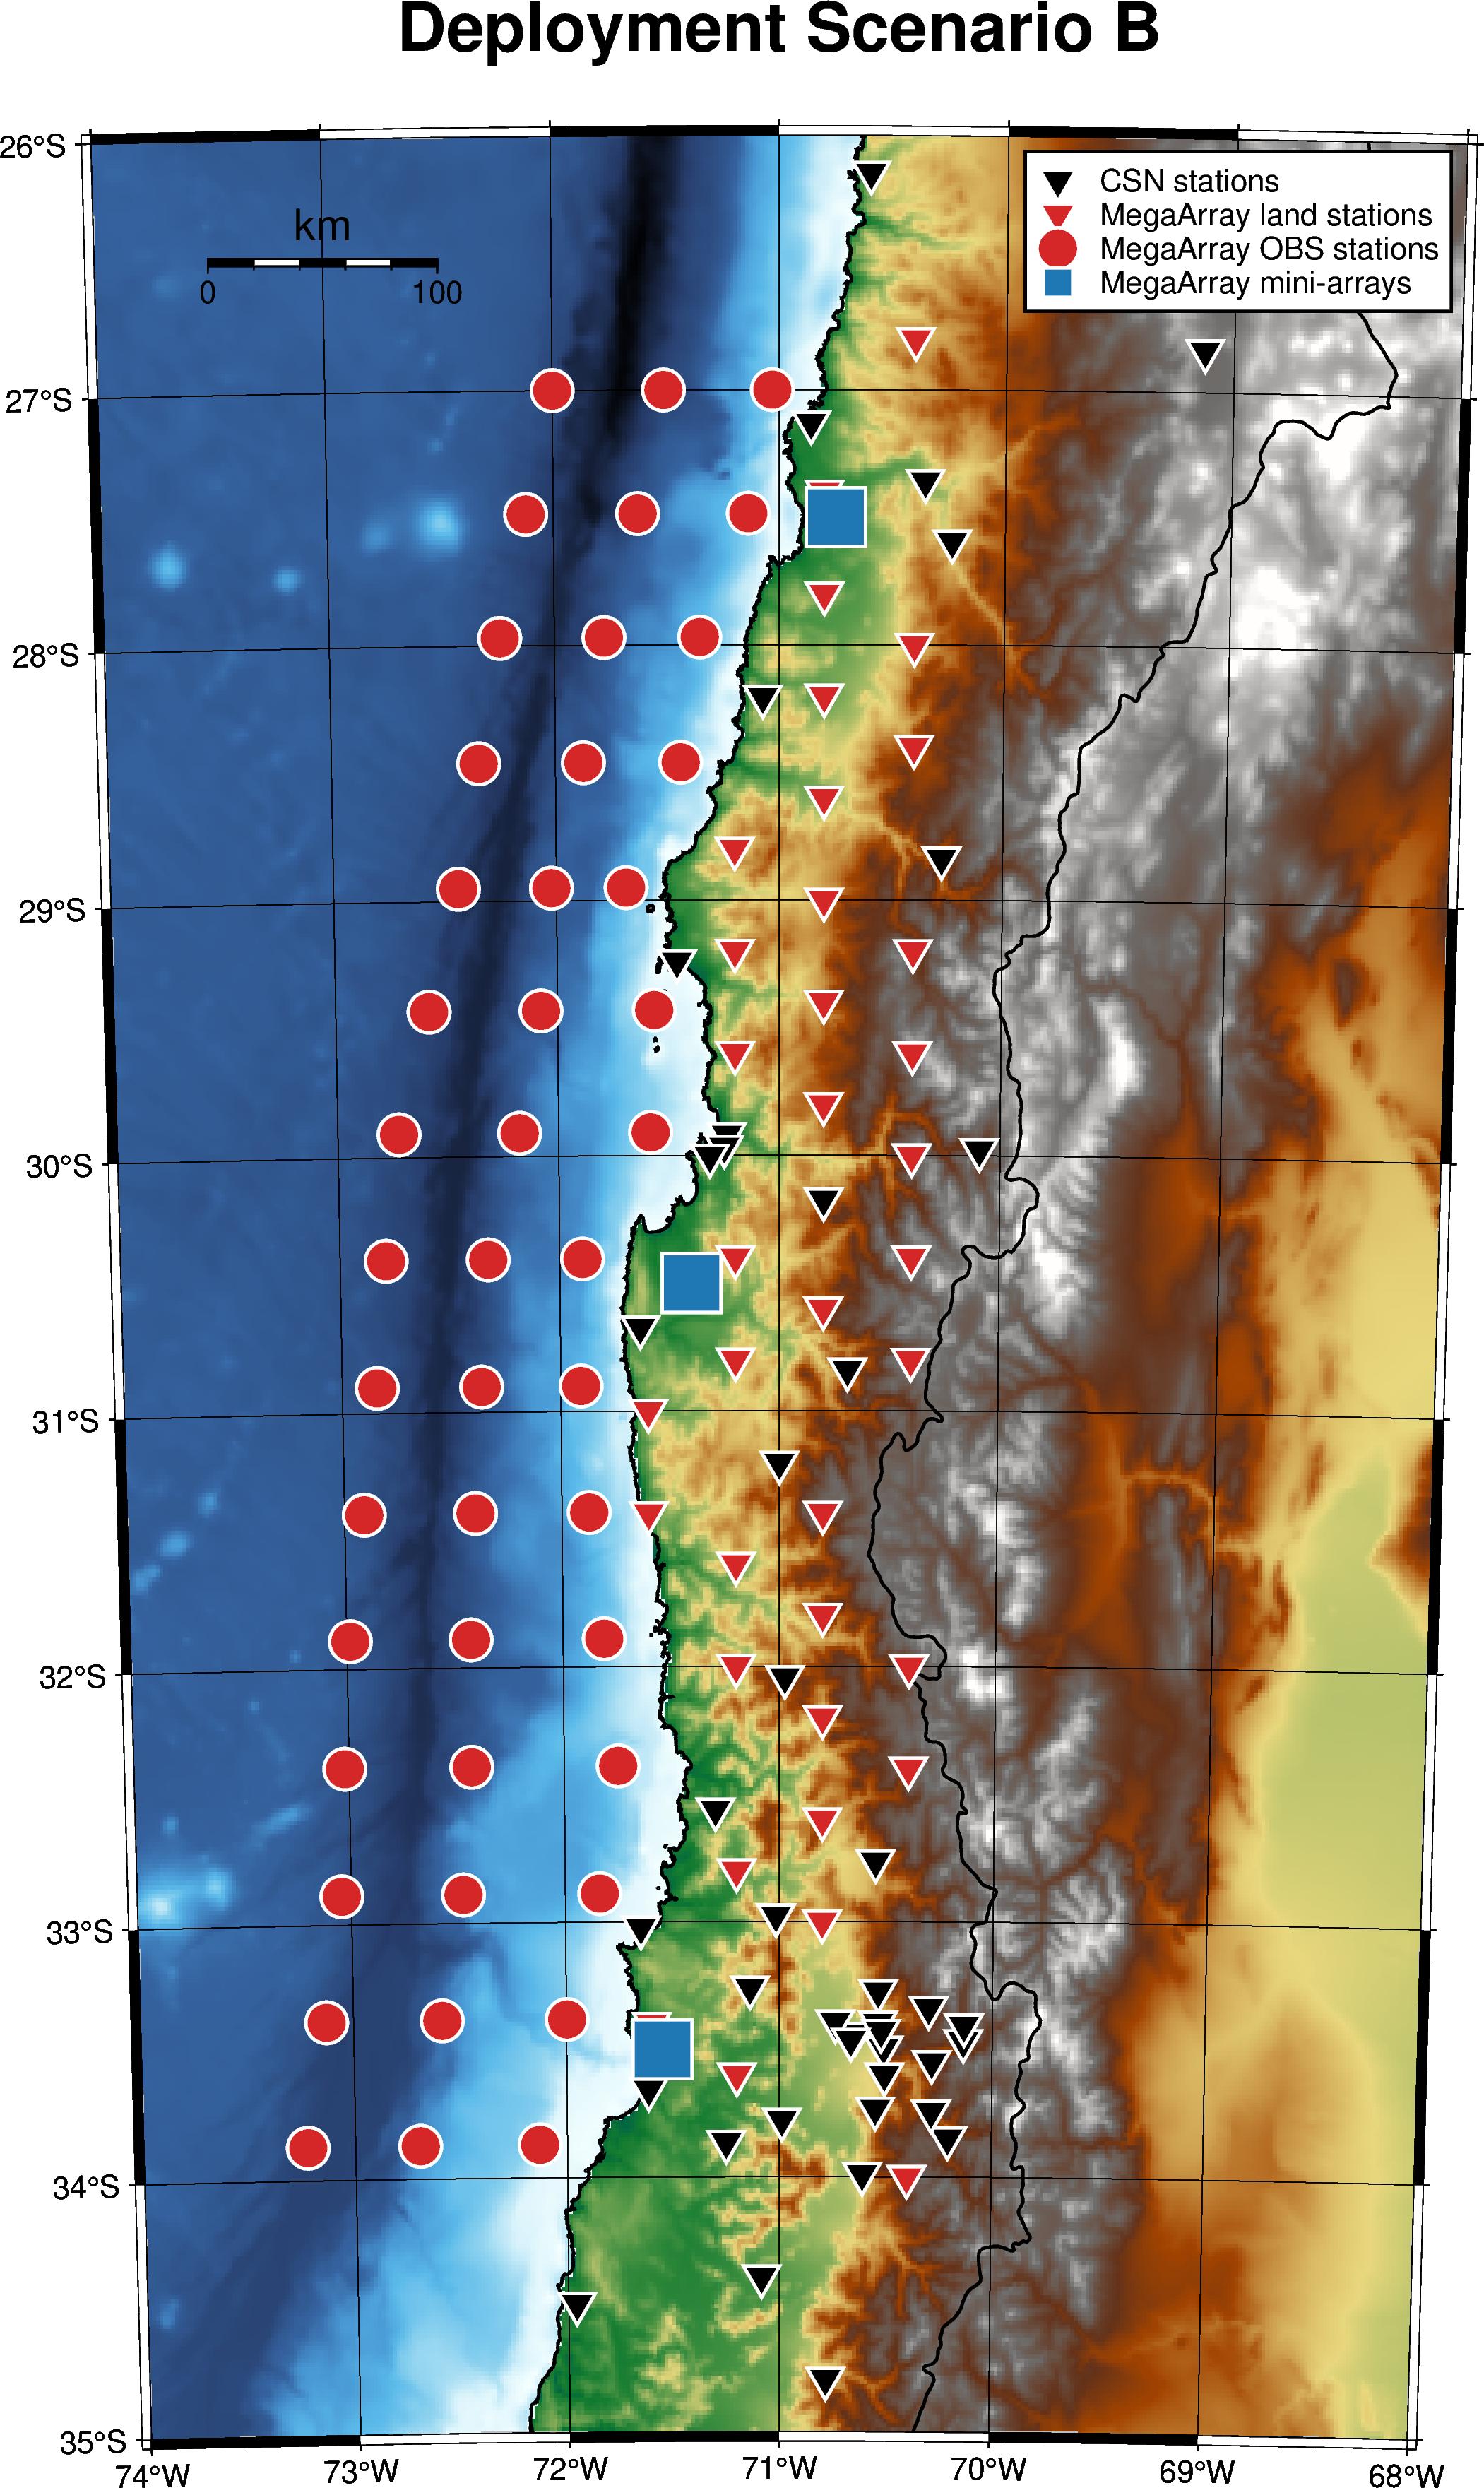

In [16]:
%matplotlib ipympl

import pygmt

FIGURE_WIDTH = 6.5 * 2.54
PLOT_EVENTS = False
PLOT_STATIONS = True
PLOT_RELIEF = True
LON_MIN, LON_MAX = -74, -68
LAT_MIN, LAT_MAX = -35, -26
LAND_COLOR = '#666666'
WATER_COLOR = 'skyblue'

lon0 = (LON_MIN + LON_MAX) / 2
lat0 = (LAT_MIN + LAT_MAX) / 2

# stations = pd.read_hdf('../data/stations.hdf5')
# stations = stations[stations['end_time'].isna()]
# events = pd.read_hdf('../data/events/events_1980-2023.hdf5')


region = f'{LON_MIN}/{LON_MAX}/{LAT_MIN}/{LAT_MAX}'


fig = pygmt.Figure()
if PLOT_RELIEF is True:
    grd = pygmt.datasets.load_earth_relief(
        resolution='01m',
        region=region
    )
    fig.grdimage(
        grid=grd,
        projection=f'B{lon0}/{lat0}/{LAT_MIN}/{LAT_MAX}/{FIGURE_WIDTH}c',
        cmap='geo',
        region=region,
        frame='ag'
    )
    LAND_COLOR = WATER_COLOR = None
else:
    fig.basemap(
        projection=f'B{lon0}/{lat0}/{LAT_MIN}/{LAT_MAX}/{FIGURE_WIDTH}c',
        region=region,
        frame='ag'
    )
fig.coast(
    borders='1/1p',
    shorelines='1/1p',
    land=LAND_COLOR,
    water=WATER_COLOR,
    frame=['ag', f'+t"Deployment Scenario {scenario}"'],
    map_scale='g-73/-26.5+w100k+f+lkm'
)
if PLOT_EVENTS is True:
    _events = events[events['magnitude'] > 3]
    pygmt.makecpt(cmap='hot', series=[0, 250])
    fig.plot(
        x=_events['longitude'],
        y=_events['latitude'],
        style='c',
        color=_events['depth'],
        cmap=True,
        size=0.006*2**_events['magnitude'],
        # pen='0.5p,black'
    )
    fig.colorbar()
    
if PLOT_STATIONS is True:
    fig.plot(
        x=csn_stations['longitude'],
        y=csn_stations['latitude'],
        style='i0.5c',
        color='black',
        pen='1p,white',
        label='"CSN stations"+S0.5c'
    )
    # stations_ = stations[~stations['is_array']]
    fig.plot(
        x=onshore_stations['longitude'],
        y=onshore_stations['latitude'],
        style='i0.5c',
        color=project.TAB_RED,
        pen='1p,white',
        label='"MegaArray land stations"+S0.5c'
    )
    fig.plot(
        x=offshore_stations['longitude'],
        y=offshore_stations['latitude'],
        style='c0.5c',
        color=project.TAB_RED,
        pen='1p,white',
        label='"MegaArray OBS stations"+S0.5c'
    )
    # stations_ = stations[stations['is_array']]
    fig.plot(
        x=mini_arrays[:, 0],
        y=mini_arrays[:, 1],
        style='s1c',
        color=project.TAB_BLUE,
        pen='1p,white',
        label='"MegaArray mini-arrays"+S0.5c'
    )

fig.legend()
fig.show()
# fig.savefig(f'../figures/network_design/deployment_scenario_{scenario}.png')

In [17]:
len(csn_stations)

90

In [18]:
len(obs)

45

In [19]:
len(onshore_stations)

36

In [ ]:
import pygmt

FIGURE_WIDTH = 6.5 * 2.54
PLOT_EVENTS = True
PLOT_STATIONS = False
PLOT_RELIEF = True
LON_MIN, LON_MAX = -74, -68
LAT_MIN, LAT_MAX = -35, -26
LAND_COLOR = '#666666'
WATER_COLOR = 'skyblue'

lon0 = (LON_MIN + LON_MAX) / 2
lat0 = (LAT_MIN + LAT_MAX) / 2

events = pd.read_hdf('../data/events/events_1980-2023.hdf5')
events = geopandas.GeoDataFrame(
    events,
    geometry=geopandas.points_from_xy(events['longitude'], events['latitude'])
)
events_ = events[events.within(TRENCH_TRACE.buffer(1/4))]

region = f'{LON_MIN}/{LON_MAX}/{LAT_MIN}/{LAT_MAX}'


fig = pygmt.Figure()
if PLOT_RELIEF is True:
    grd = pygmt.datasets.load_earth_relief(
        resolution='01m',
        region=region
    )
    fig.grdimage(
        grid=grd,
        projection=f'B{lon0}/{lat0}/{LAT_MIN}/{LAT_MAX}/{FIGURE_WIDTH}c',
        cmap='geo',
        region=region,
        frame='ag'
    )
    LAND_COLOR = WATER_COLOR = None
else:
    fig.basemap(
        projection=f'B{lon0}/{lat0}/{LAT_MIN}/{LAT_MAX}/{FIGURE_WIDTH}c',
        region=region,
        frame='ag'
    )
fig.coast(
    borders='1/1p',
    shorelines='1/1p',
    land=LAND_COLOR,
    water=WATER_COLOR,
    frame=['ag', f'+t"Events within 1/4 degree of trench"'],
    map_scale='g-73/-26.5+w100k+f+lkm'
)
if PLOT_EVENTS is True:
    pygmt.makecpt(cmap='hot', series=[0, 64])
    fig.plot(
        x=events_['longitude'],
        y=events_['latitude'],
        style='c',
        color=events_['depth'],
        cmap=True,
        size=0.006*2**events_['magnitude'],
        # pen='0.5p,black'
    )
    fig.colorbar()
    
if PLOT_STATIONS is True:
    fig.plot(
        x=csn_stations['longitude'],
        y=csn_stations['latitude'],
        style='i0.5c',
        color='black',
        pen='1p,white',
        label='"CSN stations"+S0.5c'
    )
    # stations_ = stations[~stations['is_array']]
    fig.plot(
        x=onshore_stations['longitude'],
        y=onshore_stations['latitude'],
        style='i0.5c',
        color=TAB_RED,
        pen='1p,white',
        label='"MegaArray land stations"+S0.5c'
    )
    fig.plot(
        x=offshore_stations['longitude'],
        y=offshore_stations['latitude'],
        style='c0.5c',
        color=TAB_RED,
        pen='1p,white',
        label='"MegaArray OBS stations"+S0.5c'
    )
    # stations_ = stations[stations['is_array']]
    fig.plot(
        x=mini_arrays[:, 0],
        y=mini_arrays[:, 1],
        style='s1c',
        color=TAB_BLUE,
        pen='1p,white',
        label='"MegaArray mini-arrays"+S0.5c'
    )
    fig.legend()
fig.show()
fig.savefig('../figures/events_within_0.25_degrees_of_trench.png')

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
ax.scatter(
    events_['time'],
    events_['magnitude'],
    s=2**events_['magnitude'],
    alpha=0.5
)
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')